In [45]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import cv2
from scipy.linalg import cho_factor, cho_solve

In [46]:
# Max index = number of unknowns
def getVarIndex(x,y,width,height):
    return y+(x*width)

In [47]:
def setUpNormalSystem(width,height,constraints):

    # Constraints to array
    constraints_np = np.array(constraints)
    const_mat  = np.full((height, width),-1.,np.float)
    weight_mat = np.full((height, width),0.,np.float)
    
    const_mat[constraints_np[:, 0].astype(int), constraints_np[:, 1].astype(int)]  = constraints_np[:, 2]
    weight_mat[constraints_np[:, 0].astype(int), constraints_np[:, 1].astype(int)] = constraints_np[:, 3]
    
    # Triplet list -> (indx_constraint, unknown, val)
    A_triplet_list = []
    b_list = []
    row = 0
    
    # Set up constraints
    for x in range(0,width):
        for y in range(0,height):
            #print(x,y," --> ",getVarIndex(x,y,width,height))
            # Horizontal Smoothness
            if((x+1)!=width):
                A_triplet_list.append((row,getVarIndex(x,y,width,height),-1))
                A_triplet_list.append((row,getVarIndex(x+1,y,width,height),1))
                row = row + 1

            # Vertical Smoothness
            if((y+1)!=height):
                A_triplet_list.append((row,getVarIndex(x,y,width,height),-1))
                A_triplet_list.append((row,getVarIndex(x,y+1,width,height),1))
                row = row + 1

            # Constraints 
            if(const_mat[x,y]!=-1.):
                A_triplet_list.append((row,getVarIndex(x,y,width,height),weight_mat[x,y]))
                b_list.append((row,weight_mat[x,y]*const_mat[x,y]))              
                row = row + 1
                print(row,weight_mat[x,y]*const_mat[x,y])

    # Convert triplets to matrix A
    a = np.array(A_triplet_list)
    ymax = int(a[:, 0].max())
    xmax = int(a[:, 1].max())
    A = np.zeros((ymax+1, xmax+1), np.float)
    A[a[:, 0].astype(int), a[:, 1].astype(int)] = a[:, 2]
    A = A.astype(float)

    # Convert triplets to vector b
    const = np.array(b_list)
    b = np.zeros((A.shape[0]), np.float)
    b[const[:, 0].astype(int)] = const[:, 1]

    return A, b

In [48]:
# interpolation solver
def solveWithNormalEquation(width,height,constraints):
    # Set up linear system
    A, b = setUpNormalSystem(width,height,constraints)
    # Solve with Cholesky
    c, low = cho_factor(np.matmul(np.transpose(A),A))
    x = cho_solve((c, low), np.matmul(np.transpose(A),b))
    img = x.reshape((width, height))
    return img

In [51]:
# Set area size (number of cels = w*h)
width  = 50
height = 50

# Set list of constraints (format: [(x,y,value,weight),(x,y,value,weight),(x,y,value,weight),...])
# x and y must be in range (0 -> width-1, 0 -> height-1)
# value mus be in range 0->max_data
# weight must be in range 0.->1.
constraints = [(20,20,0.,1.),(40,40,130.,1.)]

2023 0.0
4044 130.0


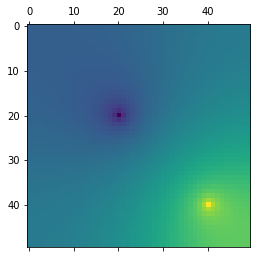

In [52]:
# Solve linear interpolation
interpolated = solveWithNormalEquation(width,height,constraints)
# Interpolated is a 2D array of size (width,height). Each cel contains the interpolated value.
plt.matshow(interpolated)

In [44]:
# Always check values (debug)
print(interpolated)

[[40.65359621 40.65359621 40.65371846 ... 45.90311004 45.93552015
  45.9517602 ]
 [40.65359621 40.65347396 40.65335171 ... 45.91913943 45.95169021
  45.96800025]
 [40.65371846 40.65335171 40.65274031 ... 45.95127031 45.98410103
  46.00055032]
 ...
 [45.90311004 45.91913943 45.95127031 ... 62.05935675 62.0445004
  62.03562791]
 [45.93552015 45.95169021 45.98410103 ... 62.0445004  62.0415429
  62.0385854 ]
 [45.9517602  45.96800025 46.00055032 ... 62.03562791 62.0385854
  62.0385854 ]]
